# EEEL 4220 Project

In [1]:
import cvxpy as cp
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import time

In [5]:
# Country to number mapping
countries = {
    "Österreich": 0, "Belgium": 1, "България": 2, "Croatia": 3, "Czechia": 4, 
    "Denmark": 5, "Estonia": 6, "Finland": 7, "France": 8, "Deutschland": 9, 
    "Greece": 10, "Hungary": 11, "Ireland": 12, "Italy": 13, "Latvia": 14, 
    "Lithuania": 15, "Luxembourg": 16, "Netherlands": 17, "Poland": 18, "Portugal": 19, 
    "Romania": 20, "Slovakia": 21, "Slovenia": 22, "Spain": 23, "Sweden": 24, 
    "Norway": 25, "Switzerland": 26, "United Kingdom": 27
}

# Line mapping to countries
line_mapping = [
    (countries["Österreich"], countries["Czechia"]),
    (countries["Österreich"], countries["Deutschland"]),
    (countries["Österreich"], countries["Hungary"]),
    (countries["Österreich"], countries["Italy"]),
    (countries["Österreich"], countries["Slovenia"]),
    (countries["Belgium"], countries["Deutschland"]),
    (countries["Belgium"], countries["France"]),
    (countries["Belgium"], countries["Luxembourg"]),
    (countries["Belgium"], countries["Netherlands"]),
    (countries["България"], countries["Greece"]),
    (countries["България"], countries["Romania"]),
    (countries["Croatia"], countries["Hungary"]),
    (countries["Croatia"], countries["Slovenia"]),
    (countries["Czechia"], countries["Deutschland"]),
    (countries["Czechia"], countries["Poland"]),
    (countries["Czechia"], countries["Slovakia"]),
    (countries["Denmark"], countries["Deutschland"]),
    (countries["Denmark"], countries["Sweden"]),
    (countries["Estonia"], countries["Finland"]),
    (countries["Estonia"], countries["Latvia"]),
    (countries["Finland"], countries["Sweden"]),
    (countries["France"], countries["Deutschland"]),
    (countries["France"], countries["Spain"]),
    (countries["France"], countries["Italy"]),
    (countries["Deutschland"], countries["Luxembourg"]),
    (countries["Deutschland"], countries["Netherlands"]),
    (countries["Deutschland"], countries["Poland"]),
    (countries["Deutschland"], countries["Sweden"]),
    (countries["Hungary"], countries["Romania"]),
    (countries["Hungary"], countries["Slovenia"]),
    (countries["Hungary"], countries["Slovakia"]),
    (countries["Italy"], countries["Slovenia"]),
    (countries["Latvia"], countries["Lithuania"]),
    (countries["Lithuania"], countries["Poland"]),
    (countries["Lithuania"], countries["Sweden"]),
    (countries["Portugal"], countries["Spain"]),
    (countries["Norway"], countries["Deutschland"]),
    (countries["Norway"], countries["Denmark"]),
    (countries["Norway"], countries["Finland"]),
    (countries["Norway"], countries["United Kingdom"]),
    (countries["Norway"], countries["Sweden"]),
    (countries["Norway"], countries["Netherlands"]),
    (countries["Switzerland"], countries["Österreich"]),
    (countries["Switzerland"], countries["Deutschland"]),
    (countries["Switzerland"], countries["France"]),
    (countries["Switzerland"], countries["Italy"]),
    (countries["United Kingdom"], countries["Belgium"]),
    (countries["United Kingdom"], countries["France"]),
    (countries["United Kingdom"], countries["Ireland"]),
    (countries["United Kingdom"], countries["Netherlands"])
]

C:\Users\Jiarong Xie\AppData\Local\Temp\ipykernel_22972\1383441040.py:38: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


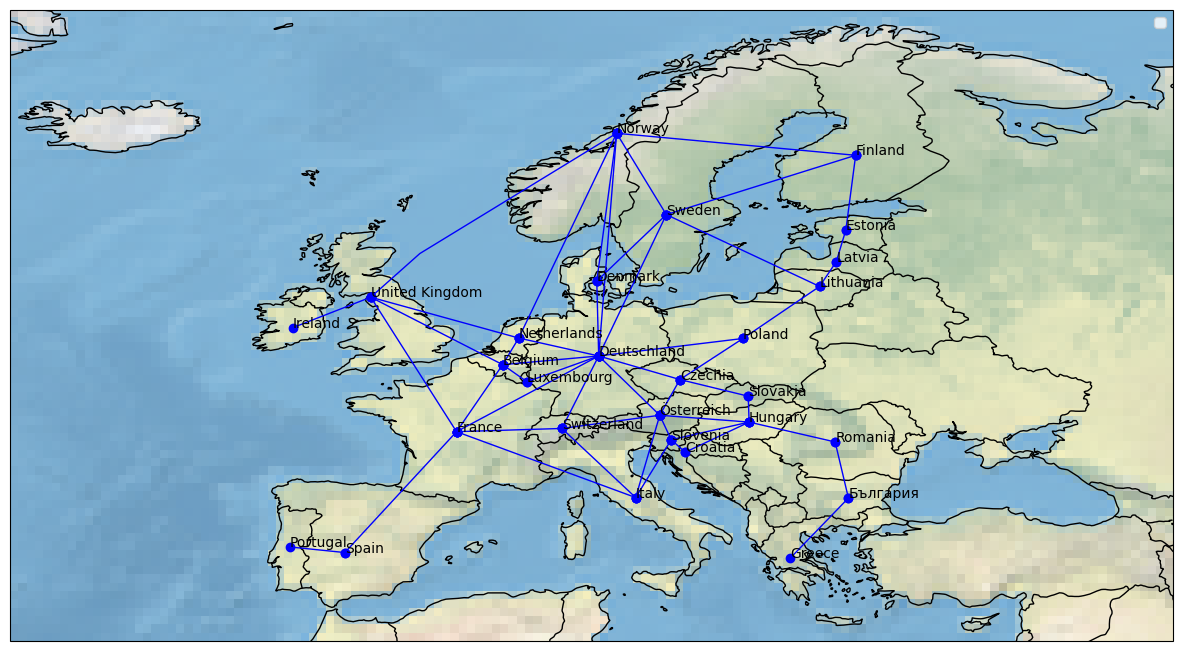

In [7]:
# Reverse mapping from number to country
num_to_country = {v: k for k, v in countries.items()}

# Initialize geolocator
geolocator = Nominatim(user_agent="Google Geocoding API (V3)")


# Function to get coordinates
def get_coordinates(country):
    location = geolocator.geocode(country, viewbox = ((70, -18), (35, 35)))
    return (location.latitude, location.longitude)

# Initialize map
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-25, 45, 34, 72], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.stock_img()

# Plot lines between countries
for from_num, to_num in line_mapping:
    from_country = num_to_country[from_num]
    to_country = num_to_country[to_num]

    from_coords = get_coordinates(from_country)
    to_coords = get_coordinates(to_country)

    plt.plot([from_coords[1], to_coords[1]], [from_coords[0], to_coords[0]],
             color="blue", linewidth=1, marker='o', transform=ccrs.Geodetic())

for country in list(countries.keys()):
    fromcoords = get_coordinates(country)
    plt.annotate(country, (fromcoords[1], fromcoords[0]), transform=ccrs.Geodetic(), label = from_num)

    # To prevent overloading the geolocator service
    time.sleep(1)
plt.legend()
# Show the plot
plt.show()

In [2]:
def optimize_power_system(demand, price, g_capacity):
    # Define the constant reactance value for each line
    num_lines = len(line_mapping)
    reactance_value = 0.2
    X = np.full(num_lines, reactance_value)

    # Define generator and line flow variables for each country
    generators = {i: cp.Variable(nonneg=True) for i in range(len(demand))}
    f = cp.Variable(num_lines)  # Line flow
    theta = cp.Variable(len(demand))  # Bus angle

    # Objective function
    obj = cp.Minimize(sum(price[i] * generators[i] for i in range(len(price))))

    # Constraints
    con_set = []
    # Nodal power balance constraints
    for i in range(len(demand)):
        # Get lines connected to this country
        incoming_lines = [j for j, (from_country, to_country) in enumerate(line_mapping) if to_country == i]
        outgoing_lines = [j for j, (from_country, to_country) in enumerate(line_mapping) if from_country == i]
        
        # Sum the inflows and outflows for lines connected to this country
        line_inflows = sum(f[j] for j in incoming_lines)  # Sum of incoming line flows
        line_outflows = sum(f[j] for j in outgoing_lines)  # Sum of outgoing line flows

        # Create nodal power balance equation
        con_set.append(generators[i] + line_inflows - line_outflows == demand[i])

    for i in range(len(demand)):
        con_set.append(generators[i] <= g_capacity[i])

    # Power flow constraints
    con_set.append(theta[0] == 0)
    con_set.extend([f[i] == (theta[from_country] - theta[to_country]) / X[i] for i, (from_country, to_country) in enumerate(line_mapping)])

    prob = cp.Problem(obj, con_set)
    prob.solve(solver = "GUROBI")

    total_generation = sum(g.value for g in generators.values())

    # Print total generation
    print("Total Generation:", total_generation)
    print("Total Demand:", demand.sum())

    # Return the solution or any other results
    bus_prices = []

    for i in range(0, len(countries)):
        bus_prices.append(con_set[i].dual_value)
    
    return prob.value, [g.value for g in generators.values()], bus_prices, f.value  #Which are the total cost, the generation amount, the bus prices, and the transmission values

In [3]:
# Country to number mapping
countries = {
    "Austria": 0, "Belgium": 1, "Bulgaria": 2, "Croatia": 3, "Czechia": 4, 
    "Denmark": 5, "Estonia": 6, "Finland": 7, "France": 8, "Germany": 9, 
    "Greece": 10, "Hungary": 11, "Ireland": 12, "Italy": 13, "Latvia": 14, 
    "Lithuania": 15, "Luxembourg": 16, "Netherlands": 17, "Poland": 18, "Portugal": 19, 
    "Romania": 20, "Slovakia": 21, "Slovenia": 22, "Spain": 23, "Sweden": 24, 
    "Norway": 25, "Switzerland": 26, "United Kingdom": 27
}

# Line mapping to countries
line_mapping = [
    (countries["Austria"], countries["Czechia"]),
    (countries["Austria"], countries["Germany"]),
    (countries["Austria"], countries["Hungary"]),
    (countries["Austria"], countries["Italy"]),
    (countries["Austria"], countries["Slovenia"]),
    (countries["Belgium"], countries["Germany"]),
    (countries["Belgium"], countries["France"]),
    (countries["Belgium"], countries["Luxembourg"]),
    (countries["Belgium"], countries["Netherlands"]),
    (countries["Bulgaria"], countries["Greece"]),
    (countries["Bulgaria"], countries["Romania"]),
    (countries["Croatia"], countries["Hungary"]),
    (countries["Croatia"], countries["Slovenia"]),
    (countries["Czechia"], countries["Germany"]),
    (countries["Czechia"], countries["Poland"]),
    (countries["Czechia"], countries["Slovakia"]),
    (countries["Denmark"], countries["Germany"]),
    (countries["Denmark"], countries["Sweden"]),
    (countries["Estonia"], countries["Finland"]),
    (countries["Estonia"], countries["Latvia"]),
    (countries["Finland"], countries["Sweden"]),
    (countries["France"], countries["Germany"]),
    (countries["France"], countries["Spain"]),
    (countries["France"], countries["Italy"]),
    (countries["Germany"], countries["Luxembourg"]),
    (countries["Germany"], countries["Netherlands"]),
    (countries["Germany"], countries["Poland"]),
    (countries["Germany"], countries["Sweden"]),
    (countries["Hungary"], countries["Romania"]),
    (countries["Hungary"], countries["Slovenia"]),
    (countries["Hungary"], countries["Slovakia"]),
    (countries["Italy"], countries["Slovenia"]),
    (countries["Latvia"], countries["Lithuania"]),
    (countries["Lithuania"], countries["Poland"]),
    (countries["Lithuania"], countries["Sweden"]),
    (countries["Portugal"], countries["Spain"]),
    (countries["Norway"], countries["Germany"]),
    (countries["Norway"], countries["Denmark"]),
    (countries["Norway"], countries["Finland"]),
    (countries["Norway"], countries["United Kingdom"]),
    (countries["Norway"], countries["Sweden"]),
    (countries["Norway"], countries["Netherlands"]),
    (countries["Switzerland"], countries["Austria"]),
    (countries["Switzerland"], countries["Germany"]),
    (countries["Switzerland"], countries["France"]),
    (countries["Switzerland"], countries["Italy"]),
    (countries["United Kingdom"], countries["Belgium"]),
    (countries["United Kingdom"], countries["France"]),
    (countries["United Kingdom"], countries["Ireland"]),
    (countries["United Kingdom"], countries["Netherlands"])
]

In [10]:
with open('countryData.pkl', 'rb') as f:
    data = pickle.load(f)
with open('genCapacityData.pkl', 'rb') as f:
    gendata = pickle.load(f)

In [15]:
# Initialize a list to store bus prices for each hour
hourly_bus_prices = []
hourly_generation = []
hourly_transmission = []
hourly_total_cost = []

for time_step in range(96):
    # Construct the price and load arrays for this time step
    P = np.array([data[country]["Day-ahead Prices"].iloc[time_step] if country not in ["Cyprus"] else 351.07 for country in countries])
    L = np.array([data[country]["Load"].iloc[time_step] if country not in ["Cyprus"] else 47.8 for country in countries])
    G_data = np.array([gendata[country].iloc[0].sum() if country not in ["Cyprus"] else 351.07 for country in countries])
    
    total_cost, generation_amounts, bus_prices, transmission = optimize_power_system(L, P, G_data)

    # Store the bus prices for this hour

    hourly_total_cost.append(total_cost)
    hourly_bus_prices.append(bus_prices)
    hourly_generation.append(generation_amounts)
    hourly_transmission.append(transmission)

Total Generation: 340656.0
Total Demand: 340656.0
Total Generation: 326316.0
Total Demand: 326316.0
Total Generation: 318637.0
Total Demand: 318637.0
Total Generation: 315185.0
Total Demand: 315185.0
Total Generation: 317897.0
Total Demand: 317897.0
Total Generation: 332283.0
Total Demand: 332283.0
Total Generation: 367502.00000000006
Total Demand: 367502.0
Total Generation: 403108.00000000006
Total Demand: 403108.0
Total Generation: 423196.0000000001
Total Demand: 423196.0
Total Generation: 427179.0000000001
Total Demand: 427179.0
Total Generation: 424235.0
Total Demand: 424235.0
Total Generation: 422157.99999999994
Total Demand: 422158.0
Total Generation: 419328.9999999999
Total Demand: 419329.0
Total Generation: 414058.0
Total Demand: 414058.0
Total Generation: 407699.00000000215
Total Demand: 407699.0
Total Generation: 403132.0
Total Demand: 403132.0
Total Generation: 398066.0
Total Demand: 398066.0
Total Generation: 400446.0
Total Demand: 400446.0
Total Generation: 415034.99999999

<Figure size 1500x800 with 0 Axes>

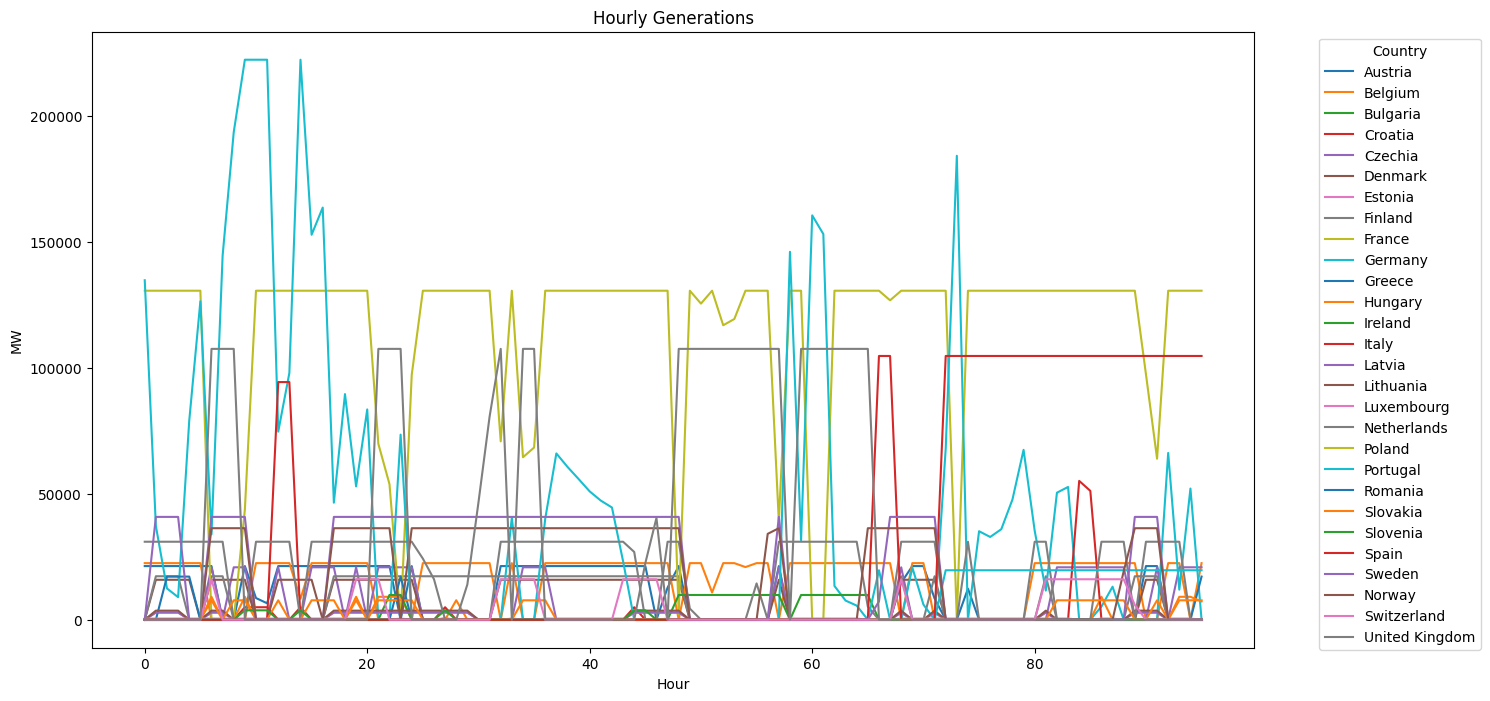

In [17]:
converted_generation = [[float(value) for value in row] for row in hourly_generation]

df_gen = pd.DataFrame(converted_generation, columns=countries.keys())

# Plotting the DataFrame as a line plot
plt.figure(figsize=(15, 8))
df_gen.plot(kind='line', figsize=(15, 8))

# Adding titles and labels
plt.title('Hourly Generations')
plt.xlabel('Hour')
plt.ylabel('MW')
#plt.ylim(-75, 75)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Displaying the plot
plt.show()

<Figure size 1500x800 with 0 Axes>

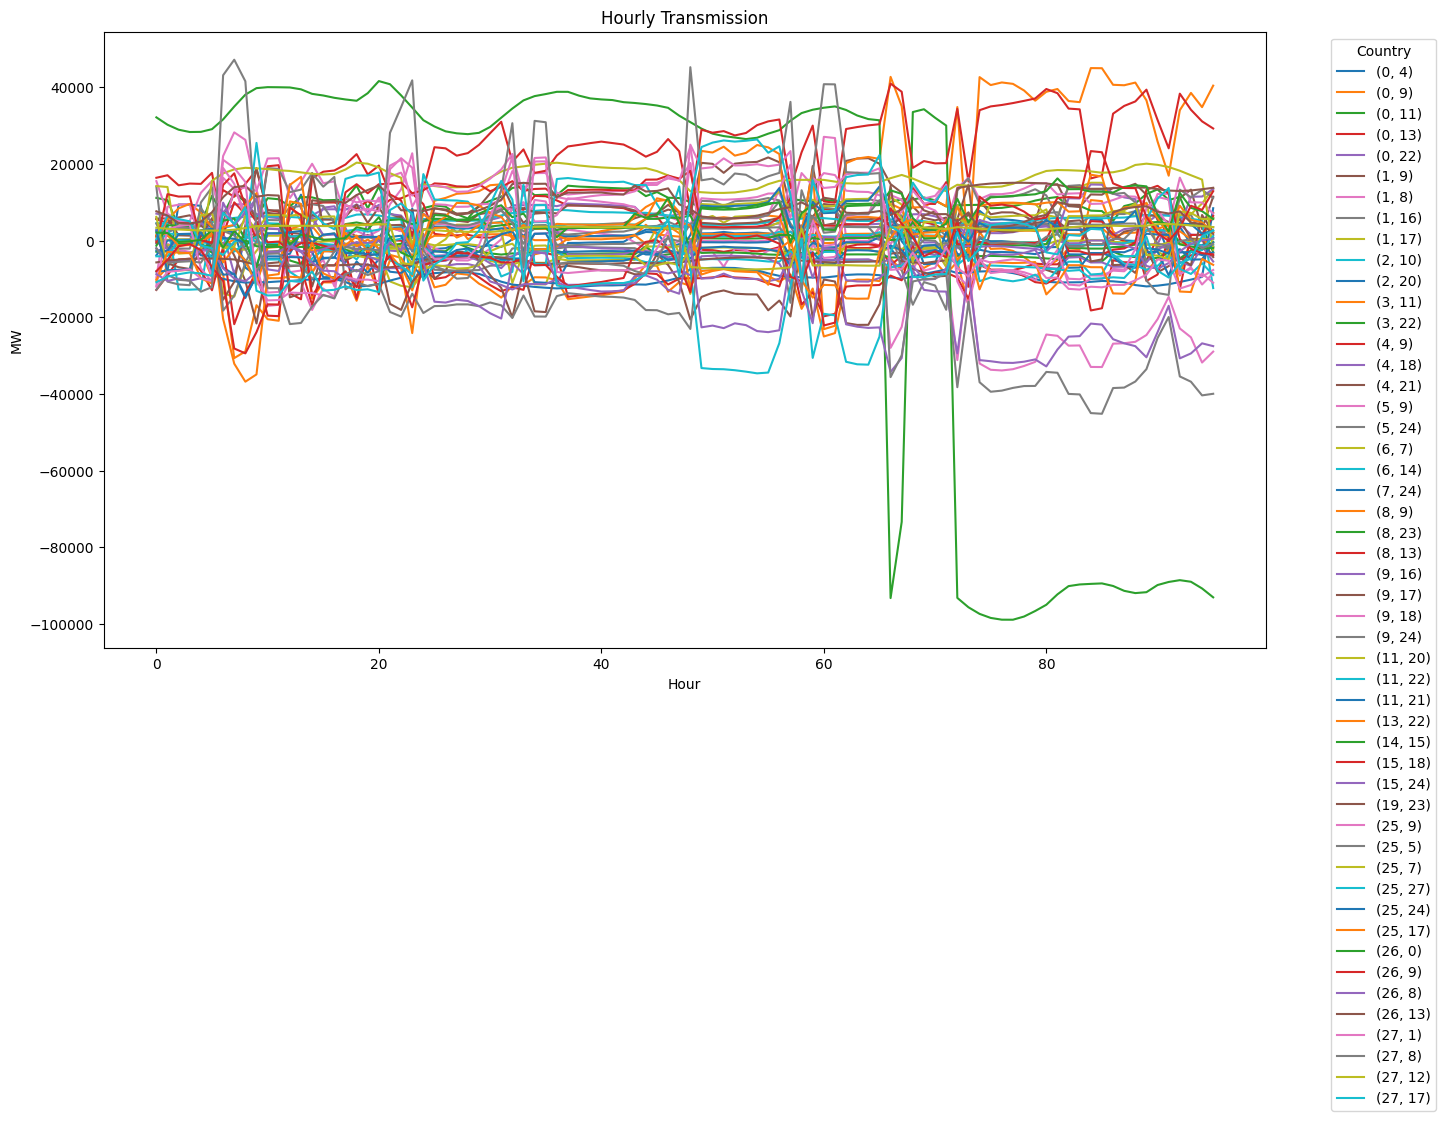

In [18]:
converted_transmision = [[float(value) for value in row] for row in hourly_transmission]

df_trans = pd.DataFrame(converted_transmision, columns = line_mapping)

# Plotting the DataFrame as a line plot
plt.figure(figsize=(15, 8))
df_trans.plot(kind='line', figsize=(15, 8))

# Adding titles and labels
plt.title('Hourly Transmission')
plt.xlabel('Hour')
plt.ylabel('MW')
#plt.ylim(-75, 75)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Displaying the plot
plt.show()

<Figure size 1500x800 with 0 Axes>

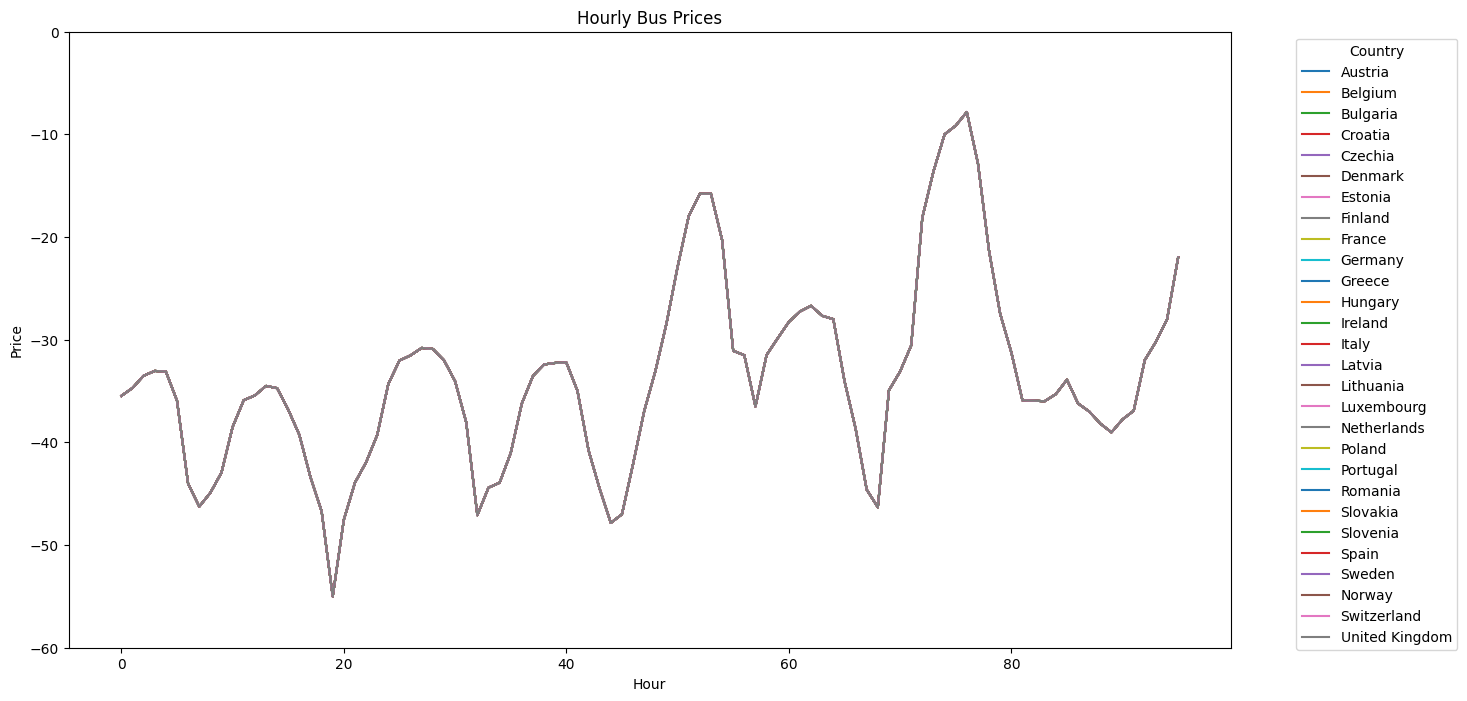

In [34]:
converted_prices = [[float(value) for value in row] for row in hourly_bus_prices]

df_prices = pd.DataFrame(converted_prices, columns=countries.keys())

# Plotting the DataFrame as a line plot
plt.figure(figsize=(15, 8))
df_prices.plot(kind='line', figsize=(15, 8))

# Adding titles and labels
plt.title('Hourly Bus Prices')
plt.xlabel('Hour')
plt.ylabel('Price')
plt.ylim(-60, 0)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Displaying the plot
plt.show()

#### The Price Differences

In [2]:
def optimize_power_system(demand, price, g_capacity):
    # Define the constant reactance value for each line
    num_lines = len(line_mapping)
    reactance_value = 0.2
    X = np.full(num_lines, reactance_value)

    # Define generator and line flow variables for each country
    generators = {i: cp.Variable(nonneg=True) for i in range(len(demand))}
    f = cp.Variable(num_lines)  # Line flow
    theta = cp.Variable(len(demand))  # Bus angle

    # Objective function
    obj = cp.Minimize(sum(price[i] * generators[i] for i in range(len(price))))

    # Constraints
    con_set = []
    # Nodal power balance constraints
    for i in range(len(demand)):
        # Get lines connected to this country
        incoming_lines = [j for j, (from_country, to_country) in enumerate(line_mapping) if to_country == i]
        outgoing_lines = [j for j, (from_country, to_country) in enumerate(line_mapping) if from_country == i]
        
        # Sum the inflows and outflows for lines connected to this country
        line_inflows = sum(f[j] for j in incoming_lines)  # Sum of incoming line flows
        line_outflows = sum(f[j] for j in outgoing_lines)  # Sum of outgoing line flows

        # Create nodal power balance equation
        con_set.append(generators[i] + line_inflows - line_outflows == demand[i])

    for i in range(len(demand)):
        con_set.append(generators[i] <= g_capacity[i])

    # Power flow constraints
    con_set.append(theta[0] == 0)
    con_set.extend([f[i] == (theta[from_country] - theta[to_country]) / X[i] for i, (from_country, to_country) in enumerate(line_mapping)])

    prob = cp.Problem(obj, con_set)
    prob.solve(solver = "GUROBI")

    total_generation = sum(g.value for g in generators.values())

    # Print total generation
    print("Total Generation:", total_generation)
    print("Total Demand:", demand.sum())

    # Return the solution or any other results
    bus_prices = []

    for i in range(0, len(countries)):
        bus_prices.append(con_set[i].dual_value)
    
    return prob.value, [g.value for g in generators.values()], bus_prices, f.value  #Which are the total cost, the generation amount, the bus prices, and the transmission values

In [3]:
# Country to number mapping
countries = {
    "Austria": 0, "Belgium": 1, "Bulgaria": 2, "Croatia": 3, "Czechia": 4, 
    "Denmark": 5, "Estonia": 6, "Finland": 7, "France": 8, "Germany": 9, 
    "Greece": 10, "Hungary": 11, "Ireland": 12, "Italy": 13, "Latvia": 14, 
    "Lithuania": 15, "Luxembourg": 16, "Netherlands": 17, "Poland": 18, "Portugal": 19, 
    "Romania": 20, "Slovakia": 21, "Slovenia": 22, "Spain": 23, "Sweden": 24, 
    "Norway": 25, "Switzerland": 26, "United Kingdom": 27
}

# Line mapping to countries
line_mapping = [
    (countries["Austria"], countries["Czechia"]),
    (countries["Austria"], countries["Germany"]),
    (countries["Austria"], countries["Hungary"]),
    (countries["Austria"], countries["Italy"]),
    (countries["Austria"], countries["Slovenia"]),
    (countries["Belgium"], countries["Germany"]),
    (countries["Belgium"], countries["France"]),
    (countries["Belgium"], countries["Luxembourg"]),
    (countries["Belgium"], countries["Netherlands"]),
    (countries["Bulgaria"], countries["Greece"]),
    (countries["Bulgaria"], countries["Romania"]),
    (countries["Croatia"], countries["Hungary"]),
    (countries["Croatia"], countries["Slovenia"]),
    (countries["Czechia"], countries["Germany"]),
    (countries["Czechia"], countries["Poland"]),
    (countries["Czechia"], countries["Slovakia"]),
    (countries["Denmark"], countries["Germany"]),
    (countries["Denmark"], countries["Sweden"]),
    (countries["Estonia"], countries["Finland"]),
    (countries["Estonia"], countries["Latvia"]),
    (countries["Finland"], countries["Sweden"]),
    (countries["France"], countries["Germany"]),
    (countries["France"], countries["Spain"]),
    (countries["France"], countries["Italy"]),
    (countries["Germany"], countries["Luxembourg"]),
    (countries["Germany"], countries["Netherlands"]),
    (countries["Germany"], countries["Poland"]),
    (countries["Germany"], countries["Sweden"]),
    (countries["Hungary"], countries["Romania"]),
    (countries["Hungary"], countries["Slovenia"]),
    (countries["Hungary"], countries["Slovakia"]),
    (countries["Italy"], countries["Slovenia"]),
    (countries["Latvia"], countries["Lithuania"]),
    (countries["Lithuania"], countries["Poland"]),
    (countries["Lithuania"], countries["Sweden"]),
    (countries["Portugal"], countries["Spain"]),
    (countries["Norway"], countries["Germany"]),
    (countries["Norway"], countries["Denmark"]),
    (countries["Norway"], countries["Finland"]),
    (countries["Norway"], countries["United Kingdom"]),
    (countries["Norway"], countries["Sweden"]),
    (countries["Norway"], countries["Netherlands"]),
    (countries["Switzerland"], countries["Austria"]),
    (countries["Switzerland"], countries["Germany"]),
    (countries["Switzerland"], countries["France"]),
    (countries["Switzerland"], countries["Italy"]),
    (countries["United Kingdom"], countries["Belgium"]),
    (countries["United Kingdom"], countries["France"]),
    (countries["United Kingdom"], countries["Ireland"]),
    (countries["United Kingdom"], countries["Netherlands"])
]

In [4]:
with open('countryData.pkl', 'rb') as f:
    data = pickle.load(f)
with open('genCapacityData.pkl', 'rb') as f:
    gendata = pickle.load(f)

Restricted license - for non-production use only - expires 2024-10-28


Total Generation: 340656.0
Total Demand: 340656.0
Total Generation: 326316.0
Total Demand: 326316.0
Total Generation: 318637.0
Total Demand: 318637.0
Total Generation: 315185.0
Total Demand: 315185.0
Total Generation: 317897.0
Total Demand: 317897.0
Total Generation: 332283.0
Total Demand: 332283.0
Total Generation: 367502.00000000006
Total Demand: 367502.0
Total Generation: 403108.00000000006
Total Demand: 403108.0
Total Generation: 423196.0000000001
Total Demand: 423196.0
Total Generation: 427179.0000000001
Total Demand: 427179.0
Total Generation: 424235.0
Total Demand: 424235.0
Total Generation: 422157.99999999994
Total Demand: 422158.0
Total Generation: 419328.9999999999
Total Demand: 419329.0
Total Generation: 414058.0
Total Demand: 414058.0
Total Generation: 407699.00000000215
Total Demand: 407699.0
Total Generation: 403132.0
Total Demand: 403132.0
Total Generation: 398066.0
Total Demand: 398066.0
Total Generation: 400446.0
Total Demand: 400446.0
Total Generation: 415034.99999999

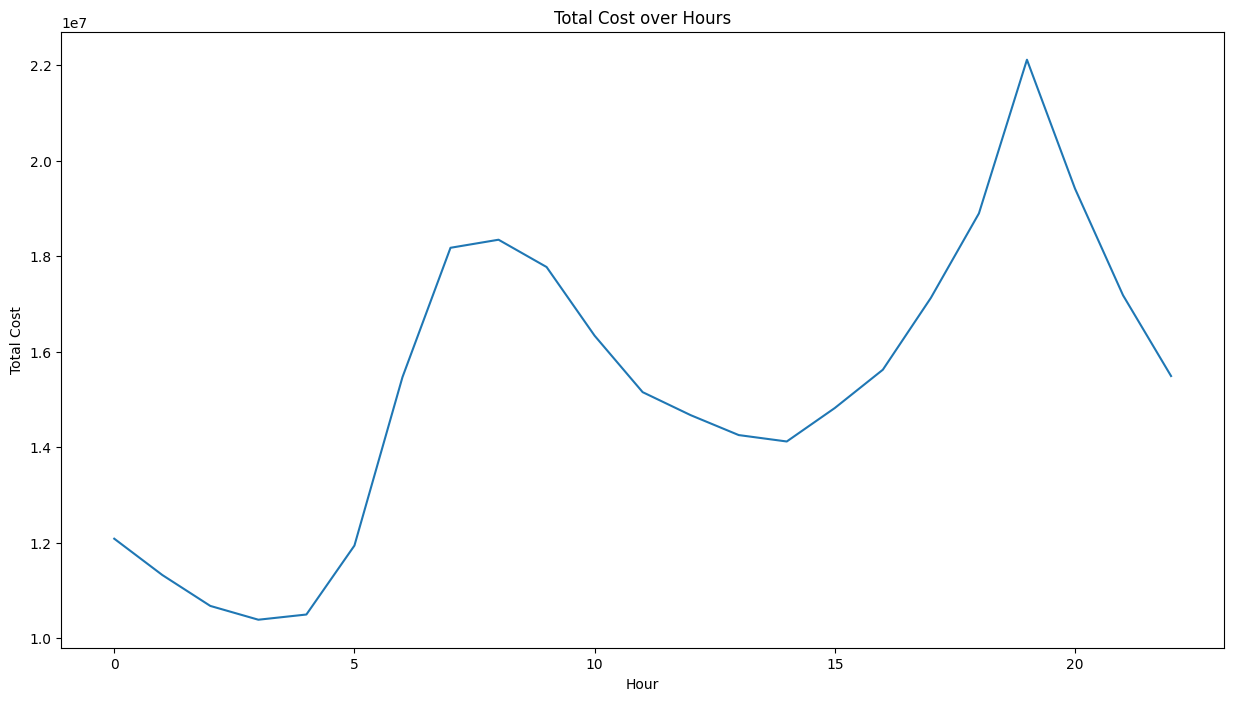

In [5]:
# Initialize a list to store bus prices for each hour
mar21_hourly_bus_prices = []
mar21_hourly_generation = []
mar21_hourly_transmission = []
mar21_hourly_total_cost = []

for time_step in range(0, 23):
    # Construct the price and load arrays for this time step
    P_mar21 = np.array([data[country]["Day-ahead Prices"].iloc[time_step] if country not in ["Cyprus"] else 351.07 for country in countries])
    L_mar21 = np.array([data[country]["Load"].iloc[time_step] if country not in ["Cyprus"] else 47.8 for country in countries])
    G_data = np.array([gendata[country].iloc[0].sum() if country not in ["Cyprus"] else 351.07 for country in countries])
    
    mar21_total_cost, mar21_generation_amounts, mar21_bus_prices, mar21_transmission = optimize_power_system(L_mar21, P_mar21, G_data)

    # Store the bus prices for this hour

    mar21_hourly_total_cost.append(mar21_total_cost)
    mar21_hourly_bus_prices.append(mar21_bus_prices)
    mar21_hourly_generation.append(mar21_generation_amounts)
    mar21_hourly_transmission.append(mar21_transmission)

plt.figure(figsize=(15, 8))
# Adding titles and labels
plt.title('Total Cost over Hours')
plt.xlabel('Hour')
plt.ylabel('Total Cost')

plt.plot(mar21_hourly_total_cost)

Total Generation: 297624.0
Total Demand: 297624.0
Total Generation: 281117.99999999994
Total Demand: 281118.0
Total Generation: 272929.99999999994
Total Demand: 272930.0
Total Generation: 266078.99999999994
Total Demand: 266079.0
Total Generation: 264576.0000000001
Total Demand: 264576.0
Total Generation: 270833.9999999994
Total Demand: 270834.0
Total Generation: 294187.99999999977
Total Demand: 294188.0
Total Generation: 328229.00000000023
Total Demand: 328229.0
Total Generation: 357017.0000000001
Total Demand: 357017.0
Total Generation: 372790.0
Total Demand: 372790.0
Total Generation: 379246.00000000006
Total Demand: 379246.0
Total Generation: 383102.00000000006
Total Demand: 383102.0
Total Generation: 384762.0
Total Demand: 384762.0
Total Generation: 382187.0
Total Demand: 382187.0
Total Generation: 376850.0
Total Demand: 376850.0
Total Generation: 372022.0
Total Demand: 372022.0
Total Generation: 367097.0
Total Demand: 367097.0
Total Generation: 363440.0
Total Demand: 363440.0
Tot

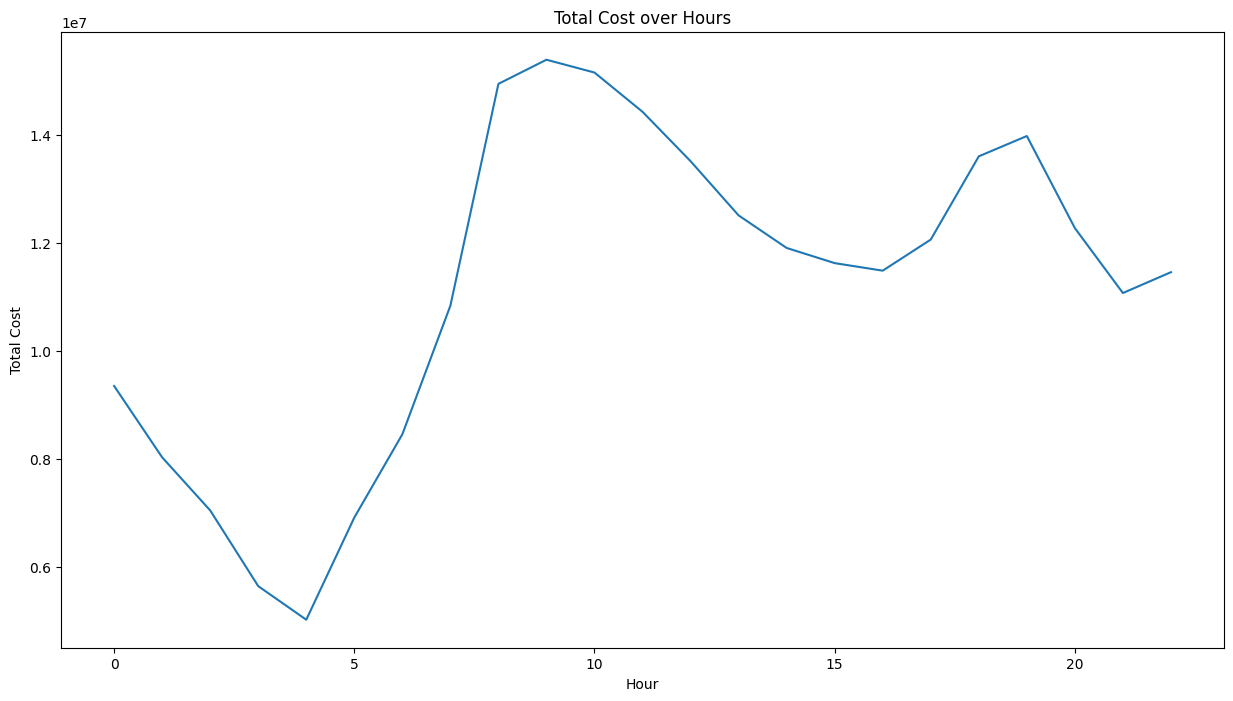

In [6]:
# Initialize a list to store bus prices for each hour
jun21_hourly_bus_prices = []
jun21_hourly_generation = []
jun21_hourly_transmission = []
jun21_hourly_total_cost = []

for time_step in range(24, 47):
    # Construct the price and load arrays for this time step
    P_jun21 = np.array([data[country]["Day-ahead Prices"].iloc[time_step] if country not in ["Cyprus"] else 351.07 for country in countries])
    L_jun21 = np.array([data[country]["Load"].iloc[time_step] if country not in ["Cyprus"] else 47.8 for country in countries])
    G_data = np.array([gendata[country].iloc[0].sum() if country not in ["Cyprus"] else 351.07 for country in countries])
    
    jun21_total_cost, jun21_generation_amounts, jun21_bus_prices, jun21_transmission = optimize_power_system(L_jun21, P_jun21, G_data)

    # Store the bus prices for this hour

    jun21_hourly_total_cost.append(jun21_total_cost)
    jun21_hourly_bus_prices.append(jun21_bus_prices)
    jun21_hourly_generation.append(jun21_generation_amounts)
    jun21_hourly_transmission.append(jun21_transmission)

plt.figure(figsize=(15, 8))
# Adding titles and labels
plt.title('Total Cost over Hours')
plt.xlabel('Hour')
plt.ylabel('Total Cost')

plt.plot(jun21_hourly_total_cost)

Total Generation: 291371.00000000006
Total Demand: 291371.0
Total Generation: 274931.0000000001
Total Demand: 274931.0
Total Generation: 265390.0000000001
Total Demand: 265390.0
Total Generation: 258842.00000000058
Total Demand: 258842.0
Total Generation: 256791.0
Total Demand: 256791.0
Total Generation: 259275.00000000012
Total Demand: 259275.0
Total Generation: 268941.00000000105
Total Demand: 268941.0
Total Generation: 284927.0000000001
Total Demand: 284927.0
Total Generation: 304611.0
Total Demand: 304611.0
Total Generation: 322508.00000000006
Total Demand: 322508.0
Total Generation: 330662.0
Total Demand: 330662.0
Total Generation: 333447.0
Total Demand: 333447.0
Total Generation: 331854.0
Total Demand: 331854.0
Total Generation: 324448.0000000001
Total Demand: 324448.0
Total Generation: 315350.0
Total Demand: 315350.0
Total Generation: 309541.00000000006
Total Demand: 309541.0
Total Generation: 307530.0
Total Demand: 307530.0
Total Generation: 312033.00000000006
Total Demand: 312

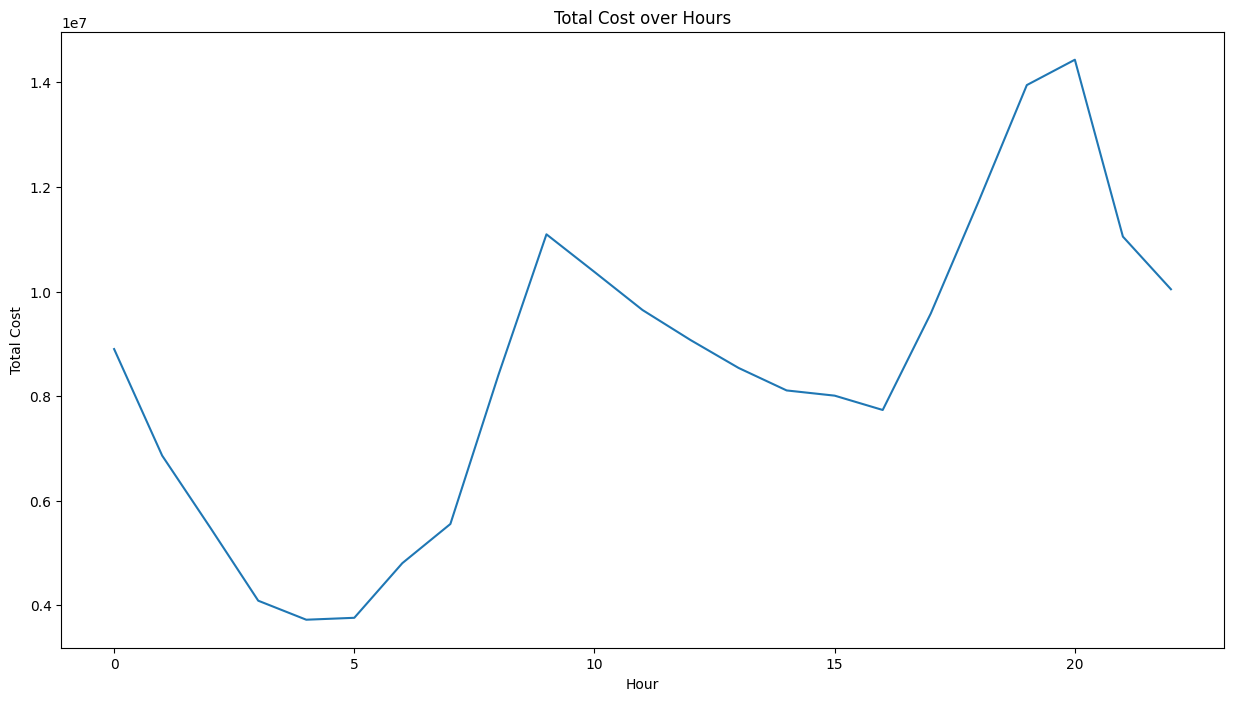

In [7]:
# Initialize a list to store bus prices for each hour
sep21_hourly_bus_prices = []
sep21_hourly_generation = []
sep21_hourly_transmission = []
sep21_hourly_total_cost = []

for time_step in range(48, 71):
    # Construct the price and load arrays for this time step
    P_sep21 = np.array([data[country]["Day-ahead Prices"].iloc[time_step] if country not in ["Cyprus"] else 351.07 for country in countries])
    L_sep21 = np.array([data[country]["Load"].iloc[time_step] if country not in ["Cyprus"] else 47.8 for country in countries])
    G_data = np.array([gendata[country].iloc[0].sum() if country not in ["Cyprus"] else 351.07 for country in countries])
    
    sep21_total_cost, sep21_generation_amounts, sep21_bus_prices, sep21_transmission = optimize_power_system(L_sep21, P_sep21, G_data)

    # Store the bus prices for this hour

    sep21_hourly_total_cost.append(sep21_total_cost)
    sep21_hourly_bus_prices.append(sep21_bus_prices)
    sep21_hourly_generation.append(sep21_generation_amounts)
    sep21_hourly_transmission.append(sep21_transmission)

plt.figure(figsize=(15, 8))
# Adding titles and labels
plt.title('Total Cost over Hours')
plt.xlabel('Hour')
plt.ylabel('Total Cost')

plt.plot(sep21_hourly_total_cost)

Total Generation: 323387.0
Total Demand: 323387.0
Total Generation: 309084.00000000006
Total Demand: 309084.0
Total Generation: 298796.0
Total Demand: 298796.0
Total Generation: 290642.0
Total Demand: 290642.0
Total Generation: 288357.0
Total Demand: 288357.0
Total Generation: 291455.0
Total Demand: 291455.0
Total Generation: 303226.00000000006
Total Demand: 303226.0
Total Generation: 322962.0
Total Demand: 322962.0
Total Generation: 344246.99999999994
Total Demand: 344247.0
Total Generation: 363132.0
Total Demand: 363132.0
Total Generation: 373014.0
Total Demand: 373014.0
Total Generation: 375296.0
Total Demand: 375296.0
Total Generation: 377248.0
Total Demand: 377248.0
Total Generation: 373282.0
Total Demand: 373282.0
Total Generation: 367871.0
Total Demand: 367871.0
Total Generation: 366652.0
Total Demand: 366652.0
Total Generation: 372325.99999999994
Total Demand: 372326.0
Total Generation: 387099.0
Total Demand: 387099.0
Total Generation: 393758.0
Total Demand: 393758.0
Total Gene

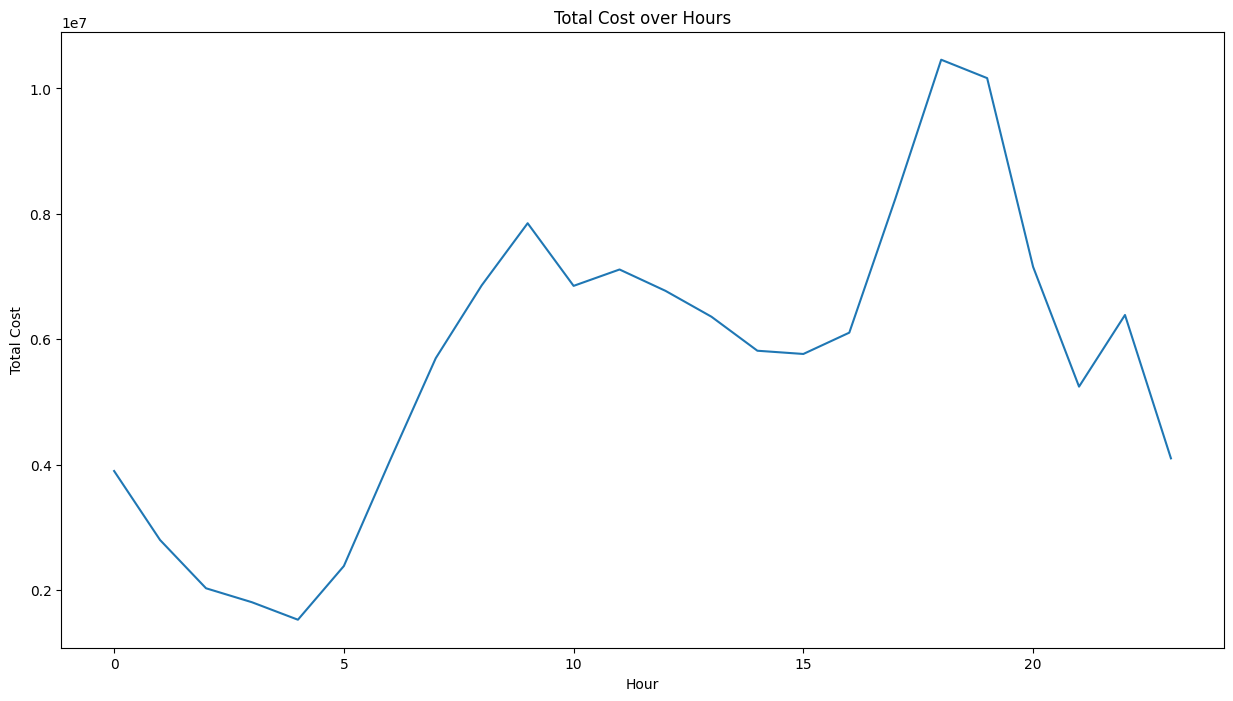

In [8]:
# Initialize a list to store bus prices for each hour
dec21_hourly_bus_prices = []
dec21_hourly_generation = []
dec21_hourly_transmission = []
dec21_hourly_total_cost = []

for time_step in range(72, 96):
    # Construct the price and load arrays for this time step
    P_dec21 = np.array([data[country]["Day-ahead Prices"].iloc[time_step] if country not in ["Cyprus"] else 351.07 for country in countries])
    L_dec21 = np.array([data[country]["Load"].iloc[time_step] if country not in ["Cyprus"] else 47.8 for country in countries])
    G_data = np.array([gendata[country].iloc[0].sum() if country not in ["Cyprus"] else 351.07 for country in countries])
    
    dec21_total_cost, dec21_generation_amounts, dec21_bus_prices, dec21_transmission = optimize_power_system(L_dec21, P_dec21, G_data)

    # Store the bus prices for this hour

    dec21_hourly_total_cost.append(dec21_total_cost)
    dec21_hourly_bus_prices.append(dec21_bus_prices)
    dec21_hourly_generation.append(dec21_generation_amounts)
    dec21_hourly_transmission.append(dec21_transmission)

plt.figure(figsize=(15, 8))
# Adding titles and labels
plt.title('Total Cost over Hours')
plt.xlabel('Hour')
plt.ylabel('Total Cost')

plt.plot(dec21_hourly_total_cost)

In [9]:
def optimize_power_system(demand, price, g_capacity):
    # Define the constant reactance value for each line
    num_lines = len(line_mapping)
    reactance_value = 0.2
    X = np.full(num_lines, reactance_value)

    # Define generator and line flow variables for each country
    generators = {i: cp.Variable(nonneg=True) for i in range(len(demand))}
    f = cp.Variable(num_lines)  # Line flow
    theta = cp.Variable(len(demand))  # Bus angle

    # Objective function
    obj = cp.Minimize(sum(price[i] * generators[i] for i in range(len(price))))

    # Constraints
    con_set = []
    # Nodal power balance constraints
    for i in range(len(demand)):
        # Get lines connected to this country
        incoming_lines = [j for j, (from_country, to_country, _) in enumerate(line_mapping) if to_country == i]
        outgoing_lines = [j for j, (from_country, to_country, _) in enumerate(line_mapping) if from_country == i]
        
        # Sum the inflows and outflows for lines connected to this country
        line_inflows = sum(f[j] for j in incoming_lines)  # Sum of incoming line flows
        line_outflows = sum(f[j] for j in outgoing_lines)  # Sum of outgoing line flows

        # Create nodal power balance equation
        con_set.append(generators[i] + line_inflows - line_outflows == demand[i])

    for i in range(len(demand)):
        con_set.append(generators[i] <= g_capacity[i])

    # Power flow constraints
    con_set.append(theta[0] == 0)
    for i, (from_country, to_country, capacity) in enumerate(line_mapping):
        # Power flow equation constraint
        con_set.append(f[i] == (theta[from_country] - theta[to_country]) / X[i])
        # Capacity constraint for each line
        con_set.append(cp.abs(f[i]) <= capacity)

    prob = cp.Problem(obj, con_set)
    prob.solve(solver = "GUROBI")

    total_generation = sum(g.value for g in generators.values())

    # Print total generation
    print("Total Generation:", total_generation)
    print("Total Demand:", demand.sum())

    # Return the solution or any other results
    bus_prices = []

    for i in range(0, len(countries)):
        bus_prices.append(con_set[i].dual_value)
    
    return prob.value, [g.value for g in generators.values()], bus_prices, f.value  #Which are the total cost, the generation amount, the bus prices, and the transmission values

In [10]:
# Country to number mapping
countries = {
    "Austria": 0, "Belgium": 1, "Bulgaria": 2, "Croatia": 3, "Cyprus": 4,
    "Czechia": 5, "Denmark": 6, "Estonia": 7, "Finland": 8, "France": 9,
    "Germany": 10, "Greece": 11, "Hungary": 12, "Ireland": 13, "Italy": 14,
    "Latvia": 15, "Lithuania": 16, "Luxembourg": 17, "Netherlands": 18, "Poland": 19, 
    "Portugal": 20, "Romania": 21, "Slovakia": 22, "Slovenia": 23, "Spain": 24, 
    "Sweden": 25, "Norway": 26, "Serbia": 27, "Switzerland": 28, "United Kingdom": 29
}

# Line mapping to countries
line_mapping = [
    (countries["Austria"], countries["Switzerland"], 1890),
    (countries["Austria"], countries["Germany"], 3670),
    (countries["Austria"], countries["Hungary"], 1830),
    (countries["Austria"], countries["Italy"], 260),
    (countries["Austria"], countries["Slovenia"], 1550),
    (countries["Belgium"], countries["Luxembourg"], 290),
    (countries["Belgium"], countries["United Kingdom"], 1040),
    (countries["Bulgaria"], countries["Greece"], 560),
    (countries["Czechia"], countries["Austria"], 2610),
    (countries["Czechia"], countries["Slovakia"], 2330),
    (countries["Germany"], countries["Belgium"], 0),
    (countries["Germany"], countries["Switzerland"], 5910),
    (countries["Germany"], countries["Czechia"], 2860),
    (countries["Germany"], countries["Luxembourg"], 790),
    (countries["Germany"], countries["Netherlands"], 5070),
    (countries["Germany"], countries["Norway"], 0),
    (countries["Germany"], countries["Poland"], 2030),
    (countries["Denmark"], countries["Germany"], 2240),
    (countries["Denmark"], countries["Norway"], 2350),
    (countries["Denmark"], countries["Sweden"], 2070),
    (countries["Estonia"], countries["Latvia"], 830),
    (countries["Finland"], countries["Estonia"], 1020),
    (countries["Finland"], countries["Sweden"], 2770),
    (countries["France"], countries["Belgium"], 3690),
    (countries["France"], countries["Switzerland"], 4190),
    (countries["France"], countries["Germany"], 5220),
    (countries["France"], countries["Spain"], 3640),
    (countries["France"], countries["United Kingdom"], 2040),
    (countries["Croatia"], countries["Slovenia"], 1500),
    (countries["Hungary"], countries["Croatia"], 1650),
    (countries["Hungary"], countries["Slovenia"], 0),
    (countries["Hungary"], countries["Slovakia"], 2010),
    (countries["Ireland"], countries["United Kingdom"], 530),
    (countries["Italy"], countries["Switzerland"], 4810),
    (countries["Italy"], countries["France"], 3560),
    (countries["Italy"], countries["Greece"], 510),
#   (countries["Italy"], countries["Malta"], 220),
    (countries["Italy"], countries["Slovenia"], 1680),
    (countries["Lithuania"], countries["Poland"], 490),
    (countries["Latvia"], countries["Lithuania"], 1190),
    (countries["Netherlands"], countries["Belgium"], 3610),
    (countries["Netherlands"], countries["Denmark"], 700),
    (countries["Netherlands"], countries["Norway"], 730),
    (countries["Netherlands"], countries["United Kingdom"], 1090),
    (countries["Norway"], countries["Finland"], 140),
    (countries["Czechia"], countries["Poland"], 1670),
    (countries["Portugal"], countries["Spain"], 3980),
    (countries["Romania"], countries["Bulgaria"], 1300),
    (countries["Romania"], countries["Hungary"], 870),
    (countries["Sweden"], countries["Germany"], 610),
    (countries["Sweden"], countries["Lithuania"], 730),
    (countries["Sweden"], countries["Norway"], 5460),
    (countries["Sweden"], countries["Poland"], 600),
    (countries["United Kingdom"], countries["Norway"], 0),
]

Total Generation: 345406.8
Total Demand: 345406.8
Total Generation: 330649.8
Total Demand: 330649.8
Total Generation: 322672.8
Total Demand: 322672.8
Total Generation: 319060.8
Total Demand: 319060.8
Total Generation: 321789.8
Total Demand: 321789.8
Total Generation: 336393.8
Total Demand: 336393.8
Total Generation: 372076.8
Total Demand: 372076.8
Total Generation: 408184.8
Total Demand: 408184.8
Total Generation: 428408.80000000005
Total Demand: 428408.8
Total Generation: 432434.8
Total Demand: 432434.8
Total Generation: 429283.8
Total Demand: 429283.8
Total Generation: 427253.8
Total Demand: 427253.8
Total Generation: 424359.8
Total Demand: 424359.8
Total Generation: 418912.8
Total Demand: 418912.8
Total Generation: 412438.8
Total Demand: 412438.8
Total Generation: 407832.8
Total Demand: 407832.8
Total Generation: 402811.8
Total Demand: 402811.8
Total Generation: 405396.8
Total Demand: 405396.8
Total Generation: 420531.8
Total Demand: 420531.8
Total Generation: 437711.8
Total Demand:

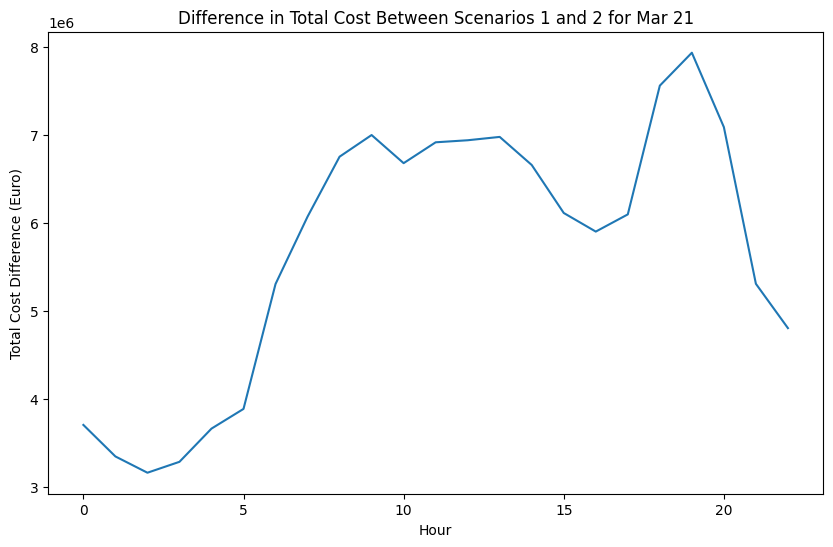

In [15]:
# Initialize a list to store bus prices for each hour
scenario_2_mar21_hourly_bus_prices = []
scenario_2_mar21_hourly_generation = []
scenario_2_mar21_hourly_transmission = []
scenario_2_mar21_hourly_total_cost = []

for time_step in range(0, 23):
    # Construct the price and load arrays for this time step
    P_mar21 = np.array([data[country]["Day-ahead Prices"].iloc[time_step] if country not in ["Cyprus"] else 351.07 for country in countries])
    L_mar21 = np.array([data[country]["Load"].iloc[time_step] if country not in ["Cyprus"] else 47.8 for country in countries])
    G_data = np.array([gendata[country].iloc[0].sum() if country not in ["Cyprus"] else 351.07 for country in countries])
    
    mar21_total_cost, mar21_generation_amounts, mar21_bus_prices, mar21_transmission = optimize_power_system(L_mar21, P_mar21, G_data)

    # Store the bus prices for this hour

    scenario_2_mar21_hourly_total_cost.append(mar21_total_cost)
    scenario_2_mar21_hourly_bus_prices.append(mar21_bus_prices)
    scenario_2_mar21_hourly_generation.append(mar21_generation_amounts)
    scenario_2_mar21_hourly_transmission.append(mar21_transmission)

scenario_2_array = np.array(scenario_2_mar21_hourly_total_cost)
mar21_array = np.array(mar21_hourly_total_cost)

# Perform element-wise subtraction
difference = scenario_2_array - mar21_array

# Plot the result
plt.figure(figsize=(10, 6))
plt.plot(difference)
plt.title('Difference in Total Cost Between Scenarios 1 and 2 for Mar 21')
plt.xlabel('Hour')
plt.ylabel('Total Cost Difference (Euro)')
plt.show()

Total Generation: 301283.80000000005
Total Demand: 301283.8
Total Generation: 284392.8
Total Demand: 284392.8
Total Generation: 275999.8
Total Demand: 275999.8
Total Generation: 269048.8
Total Demand: 269048.8
Total Generation: 267536.8
Total Demand: 267536.8
Total Generation: 273809.8
Total Demand: 273809.8
Total Generation: 297537.8
Total Demand: 297537.8
Total Generation: 332187.8
Total Demand: 332187.8
Total Generation: 361315.8
Total Demand: 361315.8
Total Generation: 377254.8
Total Demand: 377254.8
Total Generation: 383788.8
Total Demand: 383788.8
Total Generation: 387783.8
Total Demand: 387783.8
Total Generation: 389458.8
Total Demand: 389458.8
Total Generation: 386900.8
Total Demand: 386900.8
Total Generation: 381479.8
Total Demand: 381479.8
Total Generation: 376569.8
Total Demand: 376569.8
Total Generation: 371591.8
Total Demand: 371591.8
Total Generation: 367815.8
Total Demand: 367815.8
Total Generation: 365007.8
Total Demand: 365007.8
Total Generation: 359747.8
Total Demand:

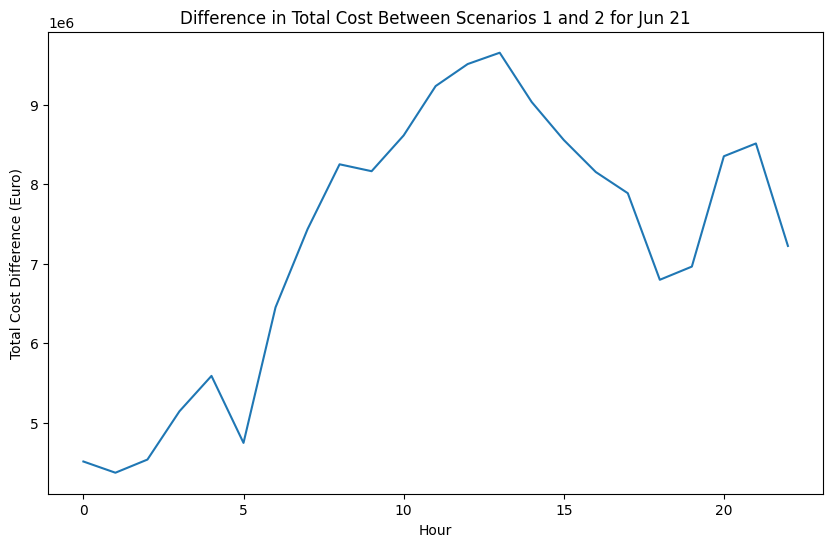

In [16]:
# Initialize a list to store bus prices for each hour
scenario_2_jun21_hourly_bus_prices = []
scenario_2_jun21_hourly_generation = []
scenario_2_jun21_hourly_transmission = []
scenario_2_jun21_hourly_total_cost = []

for time_step in range(24, 47):
    # Construct the price and load arrays for this time step
    P_jun21 = np.array([data[country]["Day-ahead Prices"].iloc[time_step] if country not in ["Cyprus"] else 351.07 for country in countries])
    L_jun21 = np.array([data[country]["Load"].iloc[time_step] if country not in ["Cyprus"] else 47.8 for country in countries])
    G_data = np.array([gendata[country].iloc[0].sum() if country not in ["Cyprus"] else 351.07 for country in countries])
    
    jun21_total_cost, jun21_generation_amounts, jun21_bus_prices, jun21_transmission = optimize_power_system(L_jun21, P_jun21, G_data)

    # Store the bus prices for this hour

    scenario_2_jun21_hourly_total_cost.append(jun21_total_cost)
    scenario_2_jun21_hourly_bus_prices.append(jun21_bus_prices)
    scenario_2_jun21_hourly_generation.append(jun21_generation_amounts)
    scenario_2_jun21_hourly_transmission.append(jun21_transmission)

scenario_2_jun21_array = np.array(scenario_2_jun21_hourly_total_cost)
jun21_array = np.array(jun21_hourly_total_cost)

# Perform element-wise subtraction
difference = scenario_2_jun21_array - jun21_array

# Plot the result
plt.figure(figsize=(10, 6))
plt.plot(difference)
plt.title('Difference in Total Cost Between Scenarios 1 and 2 for Jun 21')
plt.xlabel('Hour')
plt.ylabel('Total Cost Difference (Euro)')
plt.show()

Total Generation: 295014.80000000005
Total Demand: 295014.8
Total Generation: 278191.8
Total Demand: 278191.8
Total Generation: 268448.8
Total Demand: 268448.8
Total Generation: 261765.8
Total Demand: 261765.8
Total Generation: 259737.8
Total Demand: 259737.8
Total Generation: 262306.8
Total Demand: 262306.8
Total Generation: 272223.8
Total Demand: 272223.8
Total Generation: 288600.8
Total Demand: 288600.8
Total Generation: 308668.8
Total Demand: 308668.8
Total Generation: 326802.8
Total Demand: 326802.8
Total Generation: 334908.8
Total Demand: 334908.8
Total Generation: 337705.8
Total Demand: 337705.8
Total Generation: 336061.8
Total Demand: 336061.8
Total Generation: 328648.8
Total Demand: 328648.8
Total Generation: 319434.8
Total Demand: 319434.8
Total Generation: 313530.8
Total Demand: 313530.8
Total Generation: 311491.8
Total Demand: 311491.8
Total Generation: 315951.8
Total Demand: 315951.8
Total Generation: 325227.8
Total Demand: 325227.8
Total Generation: 335834.8
Total Demand:

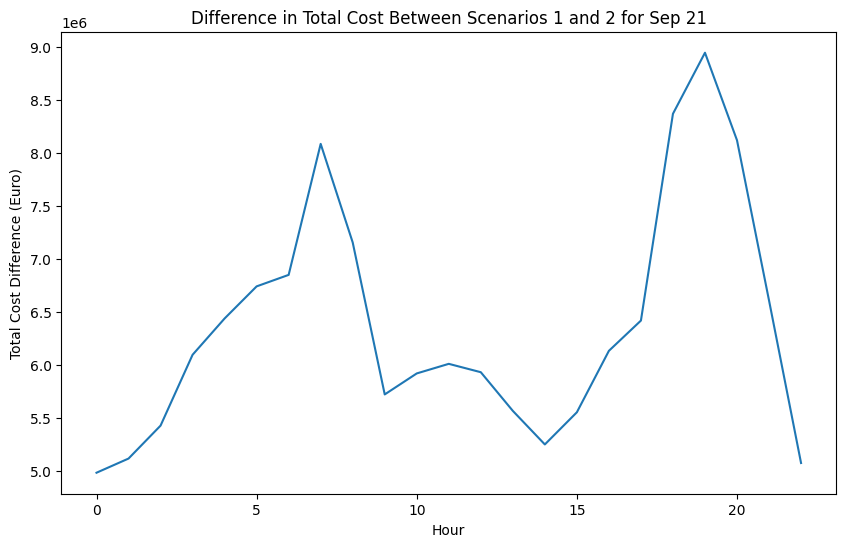

In [17]:
# Initialize a list to store bus prices for each hour
scenario_2_sep21_hourly_bus_prices = []
scenario_2_sep21_hourly_generation = []
scenario_2_sep21_hourly_transmission = []
scenario_2_sep21_hourly_total_cost = []

for time_step in range(48, 71):
    # Construct the price and load arrays for this time step
    P_sep21 = np.array([data[country]["Day-ahead Prices"].iloc[time_step] if country not in ["Cyprus"] else 351.07 for country in countries])
    L_sep21 = np.array([data[country]["Load"].iloc[time_step] if country not in ["Cyprus"] else 47.8 for country in countries])
    G_data = np.array([gendata[country].iloc[0].sum() if country not in ["Cyprus"] else 351.07 for country in countries])
    
    sep21_total_cost, sep21_generation_amounts, sep21_bus_prices, sep21_transmission = optimize_power_system(L_sep21, P_sep21, G_data)

    # Store the bus prices for this hour

    scenario_2_sep21_hourly_total_cost.append(sep21_total_cost)
    scenario_2_sep21_hourly_bus_prices.append(sep21_bus_prices)
    scenario_2_sep21_hourly_generation.append(sep21_generation_amounts)
    scenario_2_sep21_hourly_transmission.append(sep21_transmission)

scenario_2_sep21_array = np.array(scenario_2_sep21_hourly_total_cost)
sep21_array = np.array(sep21_hourly_total_cost)

# Perform element-wise subtraction
difference = scenario_2_sep21_array - sep21_array

# Plot the result
plt.figure(figsize=(10, 6))
plt.plot(difference)
plt.title('Difference in Total Cost Between Scenarios 1 and 2 for Sep 21')
plt.xlabel('Hour')
plt.ylabel('Total Cost Difference (Euro)')
plt.show()

Total Generation: 328619.8
Total Demand: 328619.8
Total Generation: 313931.8
Total Demand: 313931.8
Total Generation: 303290.8
Total Demand: 303290.8
Total Generation: 294866.8
Total Demand: 294866.8
Total Generation: 292524.80000000005
Total Demand: 292524.8
Total Generation: 295668.8
Total Demand: 295668.8
Total Generation: 307630.8
Total Demand: 307630.8
Total Generation: 327709.8
Total Demand: 327709.8
Total Generation: 349383.8
Total Demand: 349383.8
Total Generation: 368522.8
Total Demand: 368522.8
Total Generation: 378466.8
Total Demand: 378466.8
Total Generation: 380716.8
Total Demand: 380716.8
Total Generation: 382587.8
Total Demand: 382587.8
Total Generation: 378583.8
Total Demand: 378583.8
Total Generation: 373092.8
Total Demand: 373092.8
Total Generation: 371914.8
Total Demand: 371914.8
Total Generation: 377826.8
Total Demand: 377826.8
Total Generation: 392657.8
Total Demand: 392657.8
Total Generation: 399278.8
Total Demand: 399278.8
Total Generation: 394157.8
Total Demand:

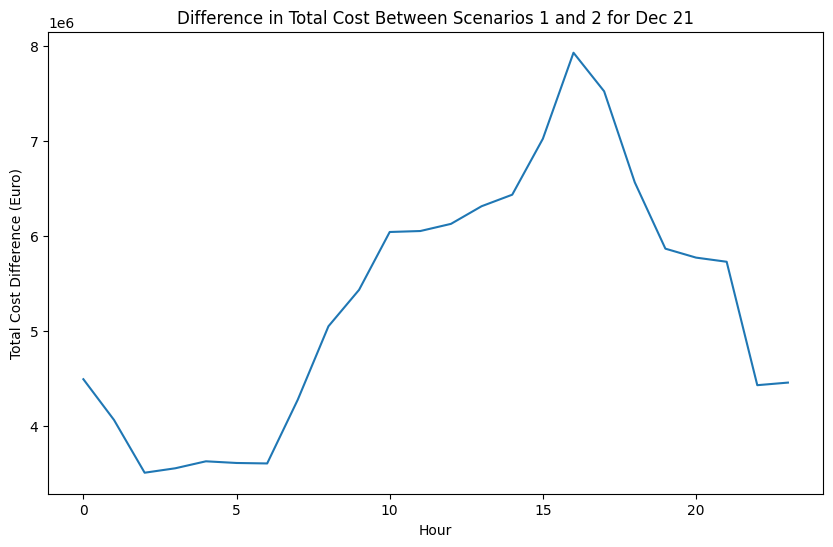

In [18]:
# Initialize a list to store bus prices for each hour
scenario_2_dec21_hourly_bus_prices = []
scenario_2_dec21_hourly_generation = []
scenario_2_dec21_hourly_transmission = []
scenario_2_dec21_hourly_total_cost = []

for time_step in range(72, 96):
    # Construct the price and load arrays for this time step
    P_dec21 = np.array([data[country]["Day-ahead Prices"].iloc[time_step] if country not in ["Cyprus"] else 351.07 for country in countries])
    L_dec21 = np.array([data[country]["Load"].iloc[time_step] if country not in ["Cyprus"] else 47.8 for country in countries])
    G_data = np.array([gendata[country].iloc[0].sum() if country not in ["Cyprus"] else 351.07 for country in countries])
    
    dec21_total_cost, dec21_generation_amounts, dec21_bus_prices, dec21_transmission = optimize_power_system(L_dec21, P_dec21, G_data)

    # Store the bus prices for this hour

    scenario_2_dec21_hourly_total_cost.append(dec21_total_cost)
    scenario_2_dec21_hourly_bus_prices.append(dec21_bus_prices)
    scenario_2_dec21_hourly_generation.append(dec21_generation_amounts)
    scenario_2_dec21_hourly_transmission.append(dec21_transmission)

scenario_2_dec21_array = np.array(scenario_2_dec21_hourly_total_cost)
dec21_array = np.array(dec21_hourly_total_cost)

# Perform element-wise subtraction
difference = scenario_2_dec21_array - dec21_array

# Plot the result
plt.figure(figsize=(10, 6))
plt.plot(difference)
plt.title('Difference in Total Cost Between Scenarios 1 and 2 for Dec 21')
plt.xlabel('Hour')
plt.ylabel('Total Cost Difference (Euro)')
plt.show()